In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import penney_db1
from importlib import reload
reload(penney_db1);
import os

In [4]:
data1 = np.random.rand(8, 8)
data2 = np.random.rand(8, 8)
n = 1
test_data = {'Cards':data1, 'Tricks':data2, 'n':n}

In [4]:
def heatmap(path_db): #path_db = 'data/database_name.db'
    db = penney_db1.DB(path_db)
    def find_prob(database):
        sql = '''
        WITH TricksWins AS (
            SELECT 
                all_combinations.p1_seq, 
                all_combinations.p2_seq, 
                COALESCE(COUNT(win_results.win_tricks), 0) AS p1_wins_by_tricks
            FROM 
                (SELECT DISTINCT p1_seq, p2_seq FROM win_results) AS all_combinations
            LEFT JOIN 
                win_results ON all_combinations.p1_seq = win_results.p1_seq 
                            AND all_combinations.p2_seq = win_results.p2_seq
                            AND win_results.win_tricks = 'p1'
            GROUP BY 
                all_combinations.p1_seq, 
                all_combinations.p2_seq
        ), 
        CardWins AS (
            SELECT 
                all_combinations.p1_seq, 
                all_combinations.p2_seq, 
                COALESCE(COUNT(win_results.win_cards), 0) AS p1_wins_by_cards
            FROM 
                (SELECT DISTINCT p1_seq, p2_seq FROM win_results) AS all_combinations
            LEFT JOIN 
                win_results ON all_combinations.p1_seq = win_results.p1_seq 
                            AND all_combinations.p2_seq = win_results.p2_seq
                            AND win_results.win_cards = 'p1'
            GROUP BY 
                all_combinations.p1_seq, 
                all_combinations.p2_seq
        ),
        TimesPlayed AS (
            SELECT 
                p1_seq, 
                p2_seq, 
                COUNT(*) AS TimesPlayed
            FROM 
                win_results
            GROUP BY 
                p1_seq, 
                p2_seq
        )
        
        SELECT 
            t.p1_seq, 
            t.p2_seq, 
            IFNULL(t.p1_wins_by_tricks, 0) AS P1TrickWinCount,
            IFNULL(c.p1_wins_by_cards, 0) AS P1CardWinCount,
            tp.TimesPlayed, 
            IFNULL(1.0 * t.p1_wins_by_tricks / tp.TimesPlayed, 0) AS P1ProbWinTricks,
            IFNULL(1.0 * c.p1_wins_by_cards / tp.TimesPlayed, 0) AS P1ProbWinCard
        FROM 
            TricksWins t
        LEFT JOIN 
            CardWins c ON t.p1_seq = c.p1_seq AND t.p2_seq = c.p2_seq
        LEFT JOIN 
            TimesPlayed tp ON t.p1_seq = tp.p1_seq AND t.p2_seq = tp.p2_seq
        ORDER BY t.p1_seq, t.p2_seq desc;
        '''
        return d.run_query(sql)
  
    def create_viz(dict):
        var_cards = dict['Cards']
        var_tricks = dict['Tricks']
        n = dict['n']
        x_axis_labels = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'] #player 1 
        y_axis_labels = ['RRR','RRB','RBR','RBB','BRR','BRB','BBR','BBB'] #player 2
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
        sns.heatmap(var_cards, annot= True, annot_kws={"size": 7},linewidths=.5, fmt=".2f", cmap='flare', 
                    ax=ax1, cbar=False, vmin=0, vmax=1)
        ax1.set_title('Win by Cards', fontsize = 13)
        ax1.set_xlabel('Player 1 Guesses', fontsize=10)
        ax1.set_ylabel('Player 2 Guesses', fontsize=10)
        ax1.set_xticklabels(x_axis_labels, fontsize=8)
        ax1.set_yticklabels(y_axis_labels, fontsize=8)
    
        sns.heatmap(var_tricks, annot= True, annot_kws={"size": 7},linewidths=.5, fmt=".2f", cmap='flare', 
                    ax=ax2, cbar=False, vmin=0, vmax=1)
        ax2.set_title('Win by Tricks', fontsize = 13)
        ax2.set_xlabel('Player 1 Guesses', fontsize=10)
        ax2.set_ylabel('Player 2 Guesses', fontsize=10)
        ax2.set_xticklabels(x_axis_labels, fontsize=8)
        ax2.set_yticklabels(y_axis_labels, fontsize=8)
        
        cbar_ax = fig.add_axes([.95, 0.11, 0.02, .77])
        cb = fig.colorbar(ax1.collections[0], cax=cbar_ax)
        cb.outline.set_linewidth(.2)
    
        plt.subplots_adjust(wspace=0.25)
        plt.suptitle("Probability of Player 1 Winning Penney's Game (n="+str(n)+')', y=1.07, fontsize = 17)
        plt.savefig('figures/heatmap_n'+str(n)+'.png', bbox_inches = 'tight', facecolor = 'white')
        plt.show()
        
    prob_df = find_prob(db)
    prob_p1card=np.reshape(prob_df['P1ProbWinCard'].values, (8,8))
    prob_p1trick=np.reshape(prob_df['P1ProbWinTricks'].values, (8,8))
    n = prob_df['TimesPlayed'][0]

    viz_input={'Cards':prob_p1card, 'Tricks':prob_p1trick, 'n':n}
    
    create_viz(viz_input)
    return

In [ ]:
heatmap('data/penney_db1.db')

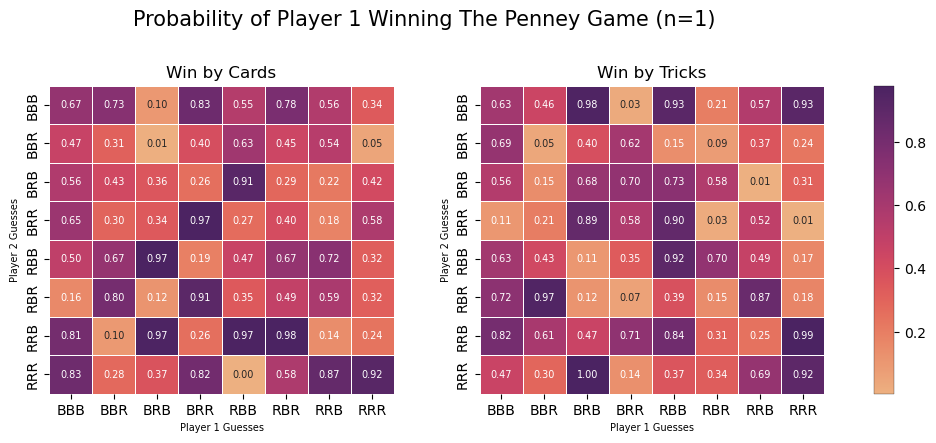

In [9]:
create_heatmap(test_data)

In [85]:
def create_viz(dict):
    var_cards = dict['Cards']
    var_tricks = dict['Tricks']
    x = var_tricks.copy()
    y = []
    for item in x:
        temp = []
        for i in item:
            temp.append(str(round(i*100))+'%')
        y.append(temp)
    n = dict['n']
    x_axis_labels = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'] #player 1 
    y_axis_labels = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'] #player 2
    ticks = ['0%','20%','40%','60%','80%','100%']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    sns.heatmap(var_cards, annot= True, annot_kws={"size": 7},linewidths=.5, fmt=".2f", cmap='flare', 
                ax=ax1, cbar=False, vmin=0, vmax=1, cbar_kws={'ticks': ticks}) 
    ax1.set_title('Win by Cards', fontsize = 13)
    ax1.set_xlabel('Player 1 Guesses', fontsize=10)
    ax1.set_ylabel('Player 2 Guesses', fontsize=10)
    ax1.set_xticklabels(x_axis_labels, fontsize=8)
    ax1.set_yticklabels(y_axis_labels, fontsize=8)

#data = np.array([[0.000000,0.000000],[-0.231049,0.000000],[-0.231049,0.000000]])
#labels =  np.array([['A','B'],['C','D'],['E','F']])
#fig, ax = plt.subplots()
#ax = sns.heatmap(data, annot = labels, fmt = '')
    sns.heatmap(var_tricks, annot= y, annot_kws={"size": 7},linewidths=.5, fmt="", cmap='flare', 
                ax=ax2, cbar=False, vmin=0, vmax=1)
    ax2.set_title('Win by Tricks', fontsize = 13)
    ax2.set_xlabel('Player 1 Guesses', fontsize=10)
    ax2.set_ylabel('Player 2 Guesses', fontsize=10)
    ax2.set_xticklabels(x_axis_labels, fontsize=8)
    ax2.set_yticklabels(y_axis_labels, fontsize=8)
    
    cbar_ax = fig.add_axes([.95, 0.11, 0.02, .77])
    cb = fig.colorbar(ax1.collections[0], cax=cbar_ax)
    cb.outline.set_linewidth(.2)
    cb.set_ticklabels([t for t in ticks])

    plt.subplots_adjust(wspace=0.25)
    plt.suptitle("Probability of Player 1 Winning Penney's Game (n="+str(n)+')', y=1.07, fontsize = 17)
    plt.savefig('figures/heatmap_n'+str(n)+'.png', bbox_inches = 'tight', facecolor = 'white')
    plt.show()

/tmp/ipykernel_115/1971623001.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.set_ticklabels([t for t in ticks])


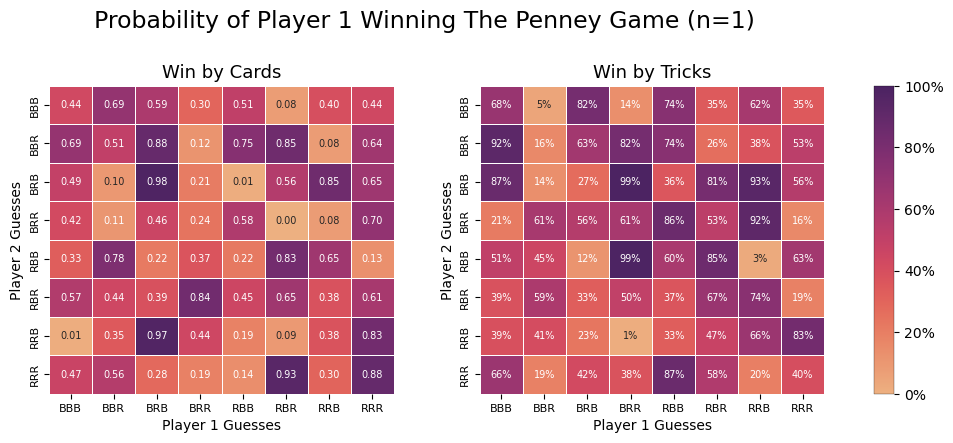

In [86]:
create_viz(test_data)

### documentation notes

- the input to the heatmap function must be a database that is in the correct order (we need to look at it and write down what this order is)
- speaking of which we need to make sure the database is ordered by and then we need to make sure we have that order like it might be order by asc or desc etc-we should be able to limit 1 to get one of each and get the order like that
- we will need to test this to make sure the array is going in the correct order etc
- such as like if someone made their own databse instead of running the simulation fuction it has to have all the columns and the data has to be in certain type
- include that the folders need to be there
- the input for the simulation fuction is literally just the number of (decks) times you want to do it